In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import load_model

unet_model = load_model('./U_D_model/unet.h5')
disc_model = load_model('./U_D_model/discriminator.h5')

Using TensorFlow backend.


In [2]:
# MNIST Load Normalization
(_, _), (x_test, y_label) = mnist.load_data()
y_test = x_test[:1000].astype('float32') / 255. 
y_label = y_label[:1000].copy()

# conv2d input reshape (width*height*cannel)
y_test = y_test.reshape((y_test.shape[0],28,28,1))
x_test = y_test.copy()

# noise range
rn = 5

# Random broken MNIST make 
for i in range(0, x_test.shape[0]) : 
    ix = np.random.randint(0, x_test.shape[1]-rn)
    iz = np.random.randint(0, x_test.shape[1]-rn)
    ic = np.random.randint(0, x_test.shape[1]-rn)
    x_test[i, 10:20, ix:ix+rn] = 1.
    x_test[i, iz:iz+rn , 5:14] = 1.
    x_test[i, ic:ic+rn , ic:ic+rn] = 1.

In [3]:
def anomaly(x_test) :
    
    unet_predicted = unet_model.predict(x_test)
    t_predicted = disc_model.predict(unet_predicted)

    residual = x_test - unet_predicted
    residual_ = residual.reshape((residual.shape[0],)+(28,28))
    residual_ = np.stack((residual_,)*3, -1) # 3채널 배열로 변경
    
    data, rows, cols, channels = residual_.shape

    # 전체 데이터 rosw, cols, channels 순회
    for a in range(data) : 
        for i in range(rows):
            for j in range(cols):
                if residual_[a,i, j, 0] == 1 :
                    residual_[a, i, j, 0] = 255

        for i in range(rows):
            for j in range(cols):
                if residual_[a, i, j, 1] == 1 :
                    residual_[a, i, j, 1] = 0

        for i in range(rows):
            for j in range(cols):
                if residual_[a, i, j, 2] == 1 :
                    residual_[a, i, j, 2] = 0            
    return(residual_, unet_predicted, t_predicted)

anomaly, unet_predicted, t_predicted = anomaly(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


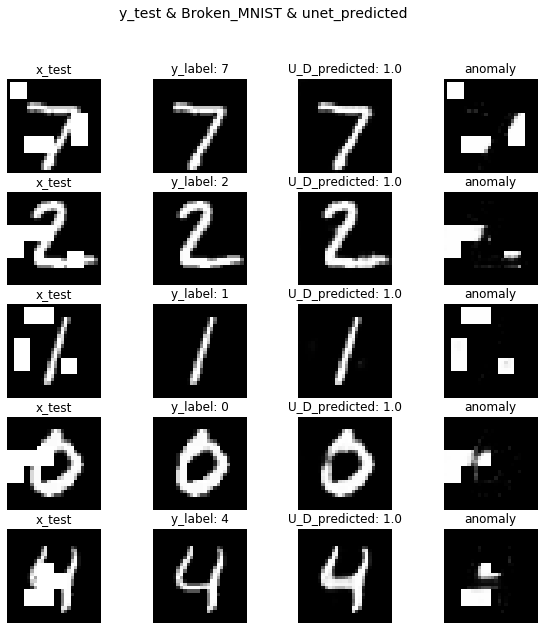

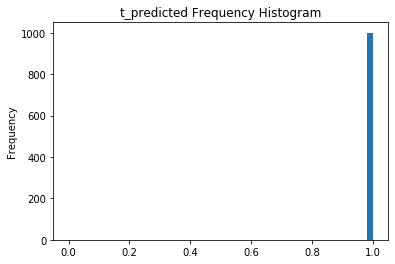

In [4]:
fig, axs = plt.subplots(5, 4 ,figsize=(10,10))
for i in range(5) :
    fig.suptitle('y_test & Broken_MNIST & unet_predicted' , fontsize=14)
    axs[i, 0].set_axis_off()
    axs[i, 0].set_title('x_test')
    axs[i, 0].imshow(x_test[i].reshape(28,28), cmap='gray')

    axs[i, 1].set_axis_off()
    axs[i, 1].set_title('y_label: %.f' % (y_label[i]))
    axs[i, 1].imshow(y_test[i].reshape(28,28), cmap='gray')

    axs[i, 2].set_axis_off()
    axs[i, 2].set_title('U_D_predicted: %.1f' % (t_predicted[i]))
    axs[i, 2].imshow(unet_predicted[i].reshape(28,28), cmap='gray')

    axs[i, 3].set_axis_off()
    axs[i, 3].set_title('anomaly') 
    axs[i, 3].imshow(anomaly[i])
    
plt.show()
plt.close(fig)

plt.hist(t_predicted, bins=50, range=(0,1))
plt.gca().set(title='t_predicted Frequency Histogram', ylabel='Frequency')
plt.show()
plt.close()


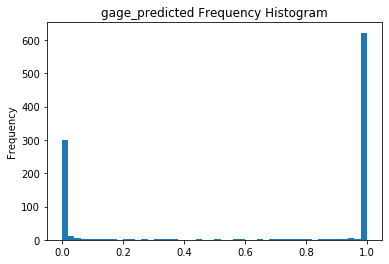

In [5]:
# dicriminator 검증
gage_predicted = disc_model.predict(x_test)

plt.hist(gage_predicted, bins=50, range=(0,1))
plt.gca().set(title='gage_predicted Frequency Histogram', ylabel='Frequency')
plt.show()
plt.close()

[1.]


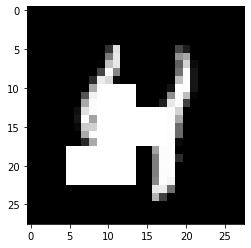

In [6]:
len_x = len(x_test)

for i in range(len_x) : 
    if gage_predicted[i] == 1 :
        print(gage_predicted[i])
        plt.imshow(x_test[i].reshape((28,28)), 'gray')
        plt.show()
        break